# Pose Estimation

Let's learn about using two different deep learning models for pose estimation. First, we will use [Yolo](https://pjreddie.com/darknet/yolo/) to detect humans in images, and second, we use Deep High-Resolution Network (HRN) to estimate the poses of the humans we detect in each image. To bootstrap this process, we have modified code from [Yolo V3](https://github.com/eriklindernoren/PyTorch-YOLOv3) and [Deep High-Resolution Network](https://github.com/leoxiaobin/deep-high-resolution-net.pytorch). We have built Docker images out of these models to make it easier for usage.

The source code for the modified code repositories are located here.

* [Yolo V3](https://github.com/oneoffcoder/docker-containers/tree/master/dl-pose-yolo)
* [Deep High-Resolution Network](https://github.com/oneoffcoder/docker-containers/tree/master/dl-pose-hrn)

The Docker images created from the modified code repositories are located here.

* [Yolo V3](https://hub.docker.com/repository/docker/oneoffcoder/dl-pose-yolo)
* [Deep High-Resolution Network](https://hub.docker.com/repository/docker/oneoffcoder/dl-pose-hrn)

Again, the big picture is this.

1. Use Yolo to detect humans.
2. Use HRN to estimate the poses per human.

The most important thing is our input to these networks. We will need to create a base directory to store inputs and outputs. The base directory in this case is called `pose-estimation` and has the following directory structure.

```
pose-estimation/
├── annots
├── cuts
├── final
├── images
│   ├── tennis-00.jpg
│   ├── tennis-01.jpg
│   ├── tennis-02.jpg
│   └── tennis-03.jpg
├── inspect
├── output
└── w32_256x256_adam_lr1e-3.yaml
```

Note the meaning of each sub-directory. You only need to have the `pose-estimation/images` directory populated.

* `annots`: stores the bounding-boxes of humans (Yolo, output)
* `cuts`: stores the JPGs of each human (Yolo, output)
* `images`: stores the input JPGs (Yolo, input)
* `inspect`: stores the JPGs with bounding-boxes (Yolo, output)
* `final`: stores the JPGs with pose estimation (HRN, output)
* `output`: stores debugging JPGs and information of pose estimation (HRN, output)

Also note the `w32_256x256_adam_lr1e-3.yaml`, which is a YAML file that configures how HRN will run. Look at the original source code to understand this format. We have modified it to take into consideration all the outputs from YOLO.

## Input Images

Here are the input images.

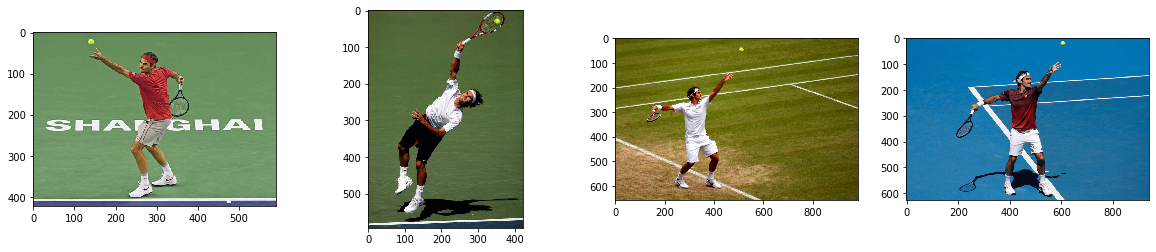

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

fpaths = [f'./pose-estimation/images/tennis-0{i}.jpg' for i in range(4)]
images = [np.asarray(Image.open(p)) for p in fpaths]

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for ax, im in zip(axes, images):
    ax.imshow(im)

## Yolo

Let's run YOLO for detecting humans.

```bash
docker run -it \
    -v `pwd`/pose-estimation:/yolo/custom \
    --gpus=all \
    --shm-size=5g \
    oneoffcoder/dl-pose-yolo \
      --image_folder custom/images \
      --annot_folder custom/annots \
      --inspect_folder custom/inspect \
      --cut_folder custom/cuts \
      --batch_size 8 \
      --n_cpu 8
```

Yolo will detect the humans with the following bounding boxes.

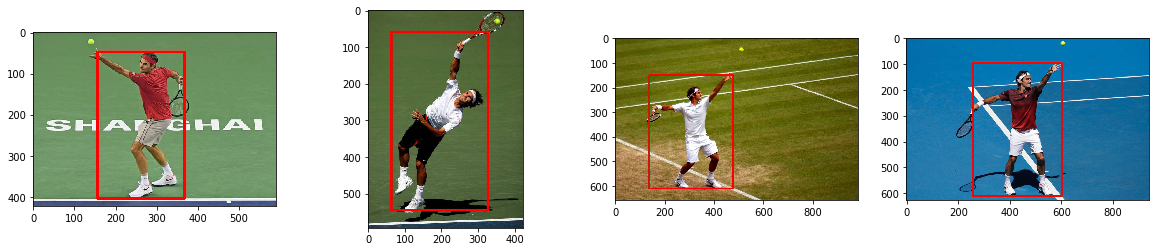

In [2]:
fpaths = [f'./pose-estimation/inspect/tennis-0{i}.jpg' for i in range(4)]
images = [np.asarray(Image.open(p)) for p in fpaths]

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for ax, im in zip(axes, images):
    ax.imshow(im)

## HRN

Let's run HRN.

```bash
docker run -it \
    -v `pwd`/pose-estimation:/hrn/custom \
    --gpus=all \
    --shm-size=5g \
    oneoffcoder/dl-pose-hrn \
      --circle 0 \
      --label 0 \
      --line 1 \
      --line_thickness 2 \
      --cfg custom/w32_256x256_adam_lr1e-3.yaml
```

HRN will estimate the poses as follows.

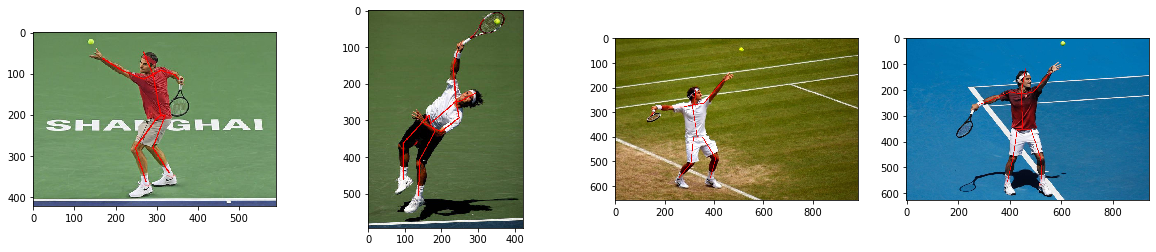

In [3]:
fpaths = [f'./pose-estimation/final/tennis-0{i}.jpg' for i in range(4)]
images = [np.asarray(Image.open(p)) for p in fpaths]

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for ax, im in zip(axes, images):
    ax.imshow(im)

## Closing thoughts

Here are some closing thoughts. You cannot simply run HRN on images with multiple humans. If there are many humans in a single image, HRN's pose estimation will spread across the humans and be incorrect. It is better to crop the humans and feed these cropped images to HRN. The Yolo Docker image does the human detection and cropping. The HRN Docker image then does the pose estimation and places the pose estimation annotations back onto the original picture (with more than one human).

While the results on the tennis images above look great, on other types of activities such as ballet or Tae Kwon Do, the pose estimation is off. You will need to train HRN instead. 